# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The data was collected from a Portuguese bank. This bank conducted direct marketing campaigns from its own call center using human agents with some use of the internet. The original dataset represents 17 marketing campaigns conducted between May 2008 and November 2010 for a total of 79354 records [Moro er al. 2014]. The dataset from UCI contains a subset of 41188 records.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import time    

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, make_scorer
from sklearn.feature_selection import SelectFromModel

warnings.filterwarnings("ignore", "use_inf_as_na")

In [2]:
bank = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
bank['y'].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

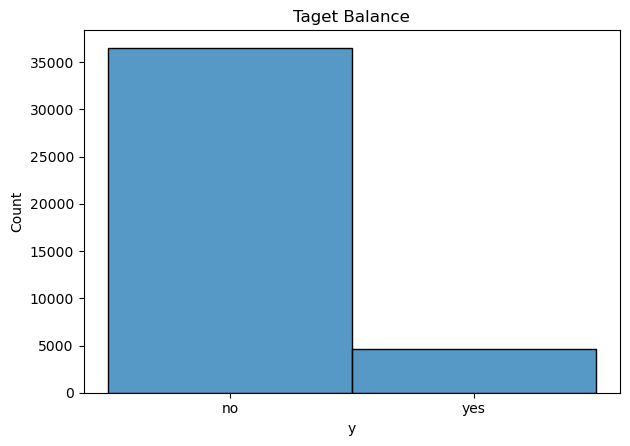

In [5]:
fig, ax = plt.subplots()
plt.title('Taget Balance')
sns.histplot(data=bank, x='y')
fig.tight_layout(rect=(0,.05,1,1)) 
plt.show()
fig.savefig("images/target_balance.png", bbox_inches='tight');

The column 'duration' has no meaningful value in predicting the classification. It is dropped.

In [6]:
bank = bank.drop('duration', axis=1)

Isolating the numerical features:

In [7]:
bank_numerical = bank.drop(['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome', 'y'], axis=1)

In [8]:
for column in bank_numerical:
    print(bank_numerical[column].describe())
    print('---------------')

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64
---------------
count    41188.000000
mean         2.567593
std          2.770014
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64
---------------
count    41188.000000
mean       962.475454
std        186.910907
min          0.000000
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: pdays, dtype: float64
---------------
count    41188.000000
mean         0.172963
std          0.494901
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: previous, dtype: float64
---------------
count    41188.000000
mean         0.081886
std          1.570960
min         -3.400000
25%         -1.800000
50%          1

The column 'campaign' appears to have outliers that will need to be dropped.

The column 'pdays' has over 95% of values indicating there was no previous contact. This column, as well as 'previous' and 'poutcome', will be dopped.



Isolating the catagorical features:

In [9]:
bank_catagorical = bank.drop(['age','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed', 'y'], axis=1)

In [10]:
for column in bank_catagorical:
    print(bank_catagorical[column].value_counts())
    print('---------------')

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
---------------
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64
---------------
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64
---------------
default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64
---------------
housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64
---------------
loan
no         33950
yes         6248
unknown      990
Name: count, d

The catagorical features will need to be converted to numerical. The features 'default', 'housing', 'loan', and 'contact' can be binary encoded. The feature 'education' can be ordinally encoded. The features 'job' ,'marital', 'month', and 'day_of_week' will be one hot encoded.

Several of the catagorical features have 'unknown' values. These are equivalent to null values. These will be converted to null and the rows containing these the 'unknown' values will be dropped.

In [11]:
print('Number of duplicate in the bank dataset: ' + str(bank.duplicated().sum()))
print(str(round(((bank.duplicated().sum() / bank.shape[0]) * 100), 2)) + '% are duplicates')

Number of duplicate in the bank dataset: 1784
4.33% are duplicates


Duplicate rows will be dropped.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The business objective is to determine how to efficiently use campaign resources to increase client subscriptions. Models will be built to predict if a client will subscribe a term deposit based on the client attributes. Mass campaigns are far less successful than directed marketing campaigns. Knowing customer tendancies will allow the business to determine where to most effectively allocate campaign resources to maximize subscriptions. 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [12]:
print('dataset row count: ' + str(bank.shape[0]))

dataset row count: 41188


Remove duplicate records.

In [13]:
bank_nodupes = bank.drop_duplicates()

In [14]:
print('dataset row count: ' + str(bank_nodupes.shape[0]))

dataset row count: 39404


Replace 'unknown' values with null and drop rows with null values.

In [15]:
bank_null = bank_nodupes.replace('unknown', None)
bank_cleaned = bank_null.dropna()

In [16]:
print('dataset row count: ' + str(bank_cleaned.shape[0]))

dataset row count: 29070


The column 'campaign' appears to have outliers.

In [17]:
bank_cleaned['campaign'].describe()

count    29070.000000
mean         2.573203
std          2.767491
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         43.000000
Name: campaign, dtype: float64

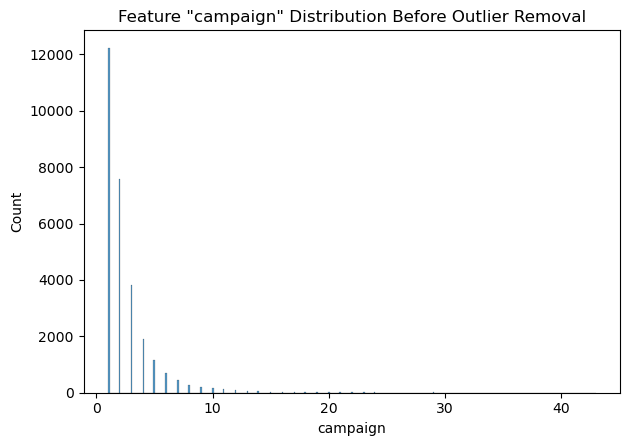

In [18]:
fig, ax = plt.subplots()
plt.title('Feature "campaign" Distribution Before Outlier Removal')
sns.histplot(data=bank_cleaned, x="campaign")
fig.tight_layout(rect=(0,.05,1,1)) 
plt.show()
fig.savefig("images/campaign_before.png", bbox_inches='tight');

In [19]:
bank_cleaned = bank_cleaned[bank_cleaned['campaign'] < 10]

In [20]:
bank_cleaned['campaign'].describe()

count    28315.000000
mean         2.241286
std          1.617079
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: campaign, dtype: float64

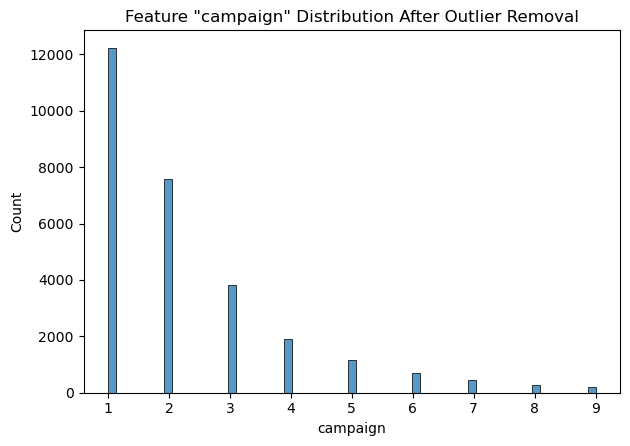

In [21]:
fig, ax = plt.subplots()
plt.title('Feature "campaign" Distribution After Outlier Removal')
sns.histplot(data=bank_cleaned, x="campaign")
fig.tight_layout(rect=(0,.05,1,1)) 
plt.show()
fig.savefig("images/campaign_after.png", bbox_inches='tight');

The column 'pdays' has over 95% of values indicating there was no previous contact. This column, as well as 'previous' and 'poutcome', are dopped.

In [22]:
bank_cleaned = bank_cleaned.drop(['pdays','previous','poutcome'], axis=1)

In [23]:
bank_cleaned.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,1,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,1,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,1,1.1,93.994,-36.4,4.857,5191.0,no
12,29,blue-collar,single,high.school,no,no,yes,telephone,may,mon,1,1.1,93.994,-36.4,4.857,5191.0,no
13,57,housemaid,divorced,basic.4y,no,yes,no,telephone,may,mon,1,1.1,93.994,-36.4,4.857,5191.0,no
14,35,blue-collar,married,basic.6y,no,yes,no,telephone,may,mon,1,1.1,93.994,-36.4,4.857,5191.0,no


In [24]:
pd.set_option('future.no_silent_downcasting', True)

The replace command is used to binary encode the features 'default', 'housing', 'loan', and 'contact'.

In [25]:
bank_cleaned[['default', 'housing', 'loan']] = bank_cleaned[['default', 'housing', 'loan']].replace({'no': 0, 'yes': 1})

In [26]:
bank_cleaned['contact'] = bank_cleaned['contact'].replace({'telephone': 0, 'cellular': 1})

Ordinal encoding is used to convert 'education' to a numerical feature.

In [27]:
ordEncoder = OrdinalEncoder(categories=[[ 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 
                                         'high.school', 'professional.course', 'university.degree']])
bank_cleaned['education'] = ordEncoder.fit_transform(bank_cleaned[['education']])

One hot encoding is used to convert 'job' ,'marital', 'month', and 'day_of_week' to numerical features.

In [28]:
bank_cleaned = pd.get_dummies(bank_cleaned, columns = ['job' ,'marital', 'month','day_of_week'], dtype=int)

In [29]:
bank_cleaned.head(10)

,age,education,default,housing,loan,contact,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,1.0,0,0,0,0,1,1.1,93.994,-36.4,...,0,1,0,0,0,0,1,0,0,0
2,37,4.0,0,1,0,0,1,1.1,93.994,-36.4,...,0,1,0,0,0,0,1,0,0,0
3,40,2.0,0,0,0,0,1,1.1,93.994,-36.4,...,0,1,0,0,0,0,1,0,0,0
4,56,4.0,0,0,1,0,1,1.1,93.994,-36.4,...,0,1,0,0,0,0,1,0,0,0
6,59,5.0,0,0,0,0,1,1.1,93.994,-36.4,...,0,1,0,0,0,0,1,0,0,0
8,24,5.0,0,1,0,0,1,1.1,93.994,-36.4,...,0,1,0,0,0,0,1,0,0,0
9,25,4.0,0,1,0,0,1,1.1,93.994,-36.4,...,0,1,0,0,0,0,1,0,0,0
12,29,4.0,0,0,1,0,1,1.1,93.994,-36.4,...,0,1,0,0,0,0,1,0,0,0
13,57,1.0,0,1,0,0,1,1.1,93.994,-36.4,...,0,1,0,0,0,0,1,0,0,0
14,35,2.0,0,1,0,0,1,1.1,93.994,-36.4,...,0,1,0,0,0,0,1,0,0,0


Separate the target from the dataset.

In [30]:
y = bank_cleaned['y']
X = bank_cleaned.drop('y', axis=1)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Scaling the data

In [32]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [33]:
dummy_start_time_ms = round(time.time() * 1000)
dummy_clf = DummyClassifier().fit(X_train, y_train)
dummy_end_time_ms = round(time.time() * 1000)

In [34]:
baseline_train_time = dummy_end_time_ms - dummy_start_time_ms
baseline_train_score = dummy_clf.score(X_train, y_train)
baseline_test_score = dummy_clf.score(X_test, y_test)

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [35]:
simple_lgr_start_time_ms = round(time.time() * 1000)
simple_lgr_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('lgr', LogisticRegression())]).fit(X_train, y_train)
simple_lgr_end_time_ms = round(time.time() * 1000)

In [36]:
simple_lgr_train_time = simple_lgr_end_time_ms - simple_lgr_start_time_ms
simple_lgr_train_score = simple_lgr_pipe.score(X_train, y_train)
simple_lgr_test_score = simple_lgr_pipe.score(X_test, y_test)

### Problem 9: Score the Model

What is the accuracy of your model?

In [37]:
print('Basline Classifier: Train Time is', baseline_train_time, 'ms,', \
      'Train Accuracy is', round(baseline_train_score, 4), ',', \
      'Test Accuracy is', round(baseline_test_score, 4))

Basline Classifier: Train Time is 10 ms, Train Accuracy is 0.8665 , Test Accuracy is 0.8652


In [38]:
print('Simple Model: Train Time is', simple_lgr_train_time, 'ms,', \
      'Train Accuracy is', round(simple_lgr_train_score, 4), ',', \
      'Test Accuracy is', round(simple_lgr_test_score, 4))

Simple Model: Train Time is 173 ms, Train Accuracy is 0.8742 , Test Accuracy is 0.8698


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

Helper functions to get and print model metrics.

In [39]:
def getMetrics(model, start_time_ms, end_time_ms):
    train_time = round(end_time_ms - start_time_ms)
    train_score = round(model.score(X_train, y_train), 4)
    test_score = round(model.score(X_test, y_test), 4)
    return [train_time, train_score, test_score]

In [40]:
def printMetrics(train_time, train_score, test_score):
    print('Train Time is', train_time, 'ms,', \
      'Train Accuracy is', train_score, ',', \
      'Test Accuracy is', test_score)

Logistic regression model with default parameters:

In [41]:
lgr_start_time_ms = round(time.time() * 1000) 
default_lgr = LogisticRegression(max_iter=100).fit(X_train, y_train)
lgr_end_time_ms = round(time.time() * 1000)

In [42]:
default_lgr_metrics = getMetrics(default_lgr, lgr_start_time_ms, lgr_end_time_ms)
print('Logistic Regression:')
printMetrics(*default_lgr_metrics)

Logistic Regression:
Train Time is 172 ms, Train Accuracy is 0.8742 , Test Accuracy is 0.8698


KNN model with default parameters:

In [43]:
knn_start_time_ms = round(time.time() * 1000) 
default_knn = KNeighborsClassifier().fit(X_train, y_train)
knn_end_time_ms = round(time.time() * 1000)

In [44]:
default_knn_metrics = getMetrics(default_knn, knn_start_time_ms, knn_end_time_ms)
print('K-Neighbors:')
printMetrics(*default_knn_metrics)

K-Neighbors:
Train Time is 33 ms, Train Accuracy is 0.8965 , Test Accuracy is 0.8601


Decision tree model with default parameters:

In [45]:
dtc_start_time_ms = round(time.time() * 1000) 
default_dtc = DecisionTreeClassifier().fit(X_train, y_train)
dtc_end_time_ms = round(time.time() * 1000)

In [46]:
default_dtc_metrics = getMetrics(default_dtc, dtc_start_time_ms, dtc_end_time_ms)
print('Decision Tree: Train Time is')
printMetrics(*default_dtc_metrics)

Decision Tree: Train Time is
Train Time is 129 ms, Train Accuracy is 0.9922 , Test Accuracy is 0.8069


Support vector machine with default parameters:

In [47]:
svc_start_time_ms = round(time.time() * 1000) 
default_svc = SVC().fit(X_train, y_train)
svc_end_time_ms = round(time.time() * 1000)

In [48]:
default_svc_metrics = getMetrics(default_svc, svc_start_time_ms, svc_end_time_ms)
print('Support Vector Machine:')
printMetrics(*default_svc_metrics)

Support Vector Machine:
Train Time is 26813 ms, Train Accuracy is 0.8918 , Test Accuracy is 0.8698


In [49]:
metric_columns = ['Train Time (ms)', 'Train Accuracy', 'Test Accuracy']
default_results = pd.DataFrame({ 
        'Logistic Regression': pd.Series(default_lgr_metrics, index=metric_columns), 
        'K-Nearest Neighbors': pd.Series(default_knn_metrics, index=metric_columns), 
        'Decision Tree': pd.Series(default_dtc_metrics, index=metric_columns),
        'Support Vector Machine': pd.Series(default_svc_metrics, index=metric_columns)}).T
default_results

,Train Time (ms),Train Accuracy,Test Accuracy
Logistic Regression,172.0,0.8742,0.8698
K-Nearest Neighbors,33.0,0.8965,0.8601
Decision Tree,129.0,0.9922,0.8069
Support Vector Machine,26813.0,0.8918,0.8698


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

Early tests showed a tendenacy toward false negatives. To reduce this tendancy, I tried 'recall' and 'balanced_accuracy' scorers. Both scorers reduced false negatives slightly, but increased false positives considerably. The 'accuracy' scoring metric yielded an accepatable balance.

#### Logistic Regression

In [50]:
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['lbfgs','newton-cholesky']    
}
tuned_lgr = GridSearchCV(LogisticRegression(random_state=42), params, cv=5, scoring='accuracy').fit(X_train, y_train)

In [51]:
print('Best parameters:')
print(tuned_lgr.best_params_)

Best parameters:
{'C': 0.1, 'solver': 'lbfgs'}


In [52]:
tuned_lgr_start_time_ms = round(time.time() * 1000) 
tuned_lgr.best_estimator_.fit(X_train, y_train)
tuned_lgr_end_time_ms = round(time.time() * 1000)

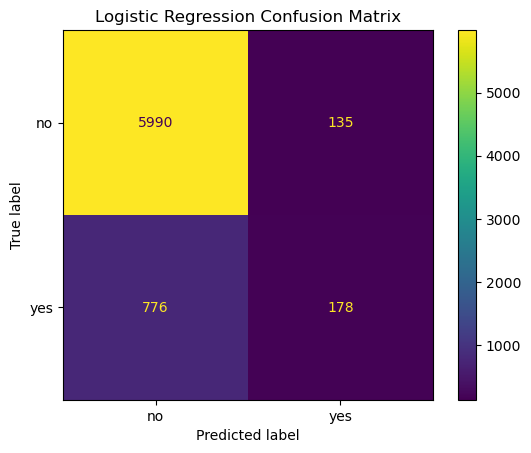

In [53]:
lgr_y_pred = tuned_lgr.predict(X_test)
lgr_cm = confusion_matrix(y_test, lgr_y_pred)

lgr_cmd = ConfusionMatrixDisplay(confusion_matrix=lgr_cm, display_labels=tuned_lgr.classes_)
fig = lgr_cmd.plot().figure_
plt.title('Logistic Regression Confusion Matrix')
plt.show()
fig.tight_layout(rect=(0,.05,1,1)) 
fig.savefig("images/lgr_con_mat.png", bbox_inches='tight');

In [54]:
tuned_lgr_train_time = round(tuned_lgr_end_time_ms - tuned_lgr_start_time_ms)
tuned_lgr_train_score = round(tuned_lgr.score(X_train, y_train), 4)
tuned_lgr_test_score = round(accuracy_score(y_test, lgr_y_pred), 4)
printMetrics(tuned_lgr_train_time, tuned_lgr_train_score, tuned_lgr_test_score)

Train Time is 105 ms, Train Accuracy is 0.8748 , Test Accuracy is 0.8713


#### K-Nearest Neighbor

In [55]:
params = {'n_neighbors': [1, 2, 5, 10],
          'weights': ['uniform', 'distance'],
           'metric': ['euclidean', 'manhattan', 'minkowski']
}
gscv_knn = GridSearchCV(KNeighborsClassifier(), params, cv=5, scoring='accuracy').fit(X_train, y_train)

In [56]:
print('Best parameters:')
print(gscv_knn.best_params_)

Best parameters:
{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}


In [57]:
tuned_knn_start_time_ms = round(time.time() * 1000) 
gscv_knn.best_estimator_.fit(X_train, y_train)
tuned_knn_end_time_ms = round(time.time() * 1000)

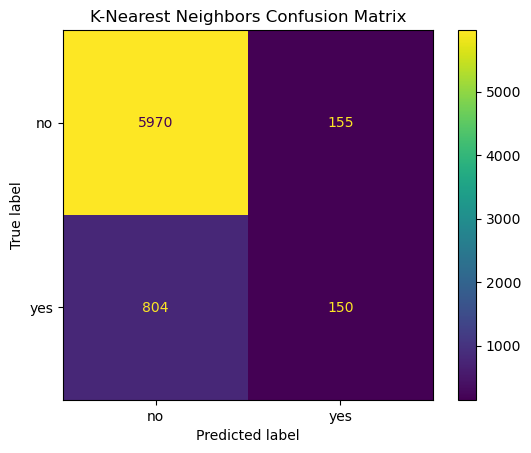

In [58]:
knn_y_pred = gscv_knn.predict(X_test)
knn_cm = confusion_matrix(y_test, knn_y_pred)

knn_cmd = ConfusionMatrixDisplay(confusion_matrix=knn_cm, display_labels=gscv_knn.classes_)
fig = knn_cmd.plot().figure_
plt.title('K-Nearest Neighbors Confusion Matrix')
plt.show()
fig.tight_layout(rect=(0,.05,1,1)) 
fig.savefig("images/knn_con_mat.png", bbox_inches='tight');

In [59]:
tuned_knn_train_time = round(tuned_knn_end_time_ms - tuned_knn_start_time_ms)
tuned_knn_train_score = round(gscv_knn.score(X_train, y_train), 4)
tuned_knn_test_score = round(accuracy_score(y_test, knn_y_pred), 4)
printMetrics(tuned_knn_train_time, tuned_knn_train_score, tuned_knn_test_score)

Train Time is 41 ms, Train Accuracy is 0.884 , Test Accuracy is 0.8645


#### Decision Tree

In [60]:
params =  {'criterion': ["gini", "entropy"],
    'max_depth': [3, 5, 8, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20, 30, 50, 80, 100, 150, 200],
    'min_samples_leaf': [1, 2, 5]
}
tuned_dtc = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5, scoring='accuracy').fit(X_train, y_train)

In [61]:
print(tuned_dtc.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 100}


In [62]:
tuned_dtc_start_time_ms = round(time.time() * 1000) 
tuned_dtc.best_estimator_.fit(X_train, y_train)
tuned_dtc_end_time_ms = round(time.time() * 1000)

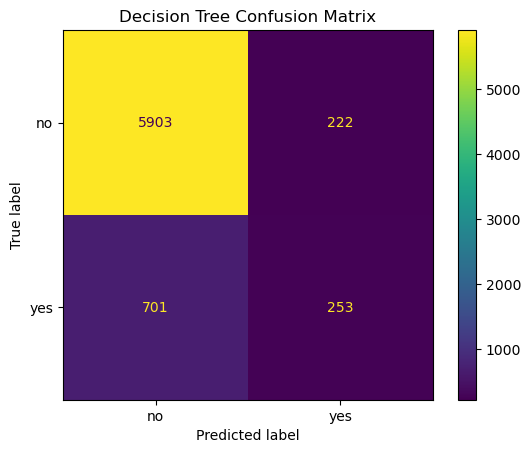

In [63]:
dtc_y_pred = tuned_dtc.predict(X_test)
dtc_cm = confusion_matrix(y_test, dtc_y_pred)

dtc_cmd = ConfusionMatrixDisplay(confusion_matrix=dtc_cm, display_labels=tuned_dtc.classes_)
fig = dtc_cmd.plot().figure_
plt.title('Decision Tree Confusion Matrix')
plt.show()
fig.tight_layout(rect=(0,.05,1,1)) 
fig.savefig("images/dtc_con_mat.png", bbox_inches='tight');

In [64]:
tuned_dtc_train_time = round(tuned_dtc_end_time_ms - tuned_dtc_start_time_ms)
tuned_dtc_train_score = round(tuned_dtc.score(X_train, y_train), 4)
tuned_dtc_test_score = round(accuracy_score(y_test, dtc_y_pred), 4)
printMetrics(tuned_dtc_train_time, tuned_dtc_train_score, tuned_dtc_test_score)

Train Time is 64 ms, Train Accuracy is 0.8831 , Test Accuracy is 0.8696


#### Support Vector Classifier

In [65]:
params = {
    'C': [1, 10],
    'kernel': ['rbf','poly']    
}
gscv_svc = GridSearchCV(SVC(random_state=42), params, return_train_score=True, cv=5, scoring='accuracy').fit(X_train, y_train)

In [66]:
print(gscv_svc.best_params_)

{'C': 1, 'kernel': 'rbf'}


In [67]:
tuned_svc_start_time_ms = round(time.time() * 1000) 
gscv_svc.best_estimator_.fit(X_train, y_train)
tuned_svc_end_time_ms = round(time.time() * 1000)

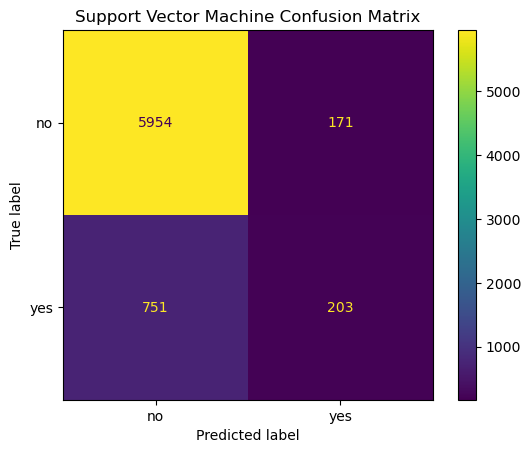

In [68]:
svc_y_pred = gscv_svc.predict(X_test)
svc_cm = confusion_matrix(y_test, svc_y_pred)

svc_cmd = ConfusionMatrixDisplay(confusion_matrix=svc_cm, display_labels=gscv_svc.classes_)
fig = svc_cmd.plot().figure_
plt.title('Support Vector Machine Confusion Matrix')
plt.show()
fig.tight_layout(rect=(0,.05,1,1)) 
fig.savefig("images/svc_con_mat.png", bbox_inches='tight');

In [69]:
tuned_svc_train_time = round(tuned_svc_end_time_ms - tuned_svc_start_time_ms)
tuned_svc_train_score = round(gscv_svc.score(X_train, y_train), 4)
tuned_svc_test_score = round(accuracy_score(y_test, svc_y_pred), 4)
printMetrics(tuned_svc_train_time, tuned_svc_train_score, tuned_svc_test_score)

Train Time is 25491 ms, Train Accuracy is 0.8918 , Test Accuracy is 0.8698


In [70]:
tuned_results = pd.DataFrame({
    'Train Time (ms)': [tuned_lgr_train_time, tuned_knn_train_time, tuned_dtc_train_time, tuned_svc_train_time],
    'Train Accuracy': [tuned_lgr_train_score, tuned_knn_train_score, tuned_dtc_train_score, tuned_svc_train_score],
    'Test Accuracy': [tuned_lgr_test_score, tuned_knn_test_score, tuned_dtc_test_score, tuned_svc_test_score]
}, index=['Logistic Regression','K-Nearest Neighbors','Decision Tree','Support Vector Machine'])
tuned_results

,Train Time (ms),Train Accuracy,Test Accuracy
Logistic Regression,105,0.8748,0.8713
K-Nearest Neighbors,41,0.8840,0.8645
Decision Tree,64,0.8831,0.8696
Support Vector Machine,25491,0.8918,0.8698


#### Additional Feature Selection

The scores might be improved with additional feature selection. This can be done for the logistic regression model and the decision tree model. The support vector classifier doesn't provide coefficients because the default kernel is RBF.

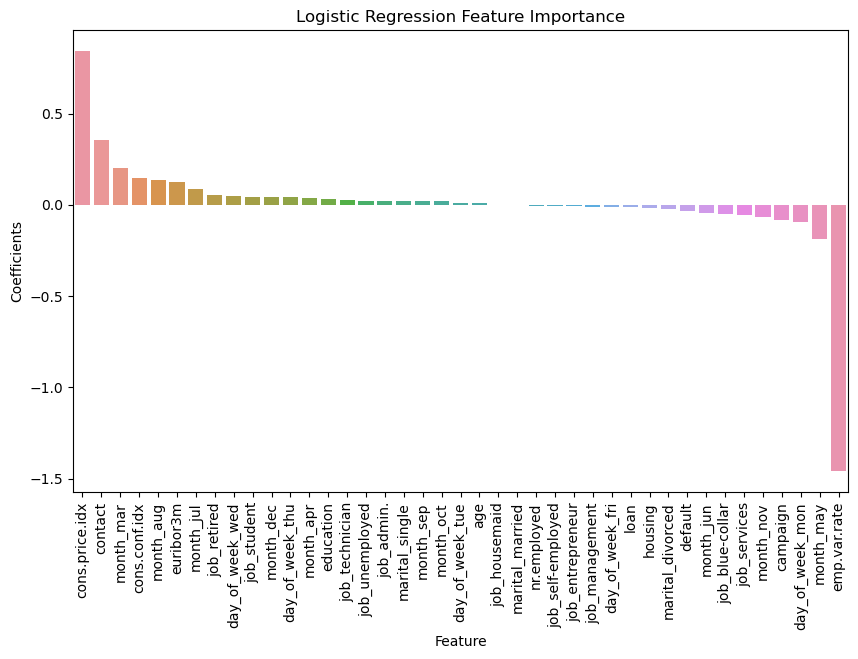

In [71]:
best_lgr = tuned_lgr.best_estimator_
lgr_feat_imp = pd.DataFrame({
    'Feature': X_train.columns.tolist(),
    'Coefficients': best_lgr.coef_[0]}).sort_values(by=['Coefficients'], ascending=False)

fig = plt.figure(figsize=(10, 6))
plt.title('Logistic Regression Feature Importance')
plt.xticks(rotation=90)
sns.barplot(lgr_feat_imp, x='Feature', y='Coefficients')
plt.show()
fig.tight_layout(rect=(0,.05,1,1)) 
fig.savefig("images/lgr_feat_imp.png", bbox_inches='tight');

In [72]:
max_score = 0
max_threshold = 0
for threshold in [1, 0.5, 0.3, 0.2, 0.15, 0.14, 0.13, 0.1, 0.09, 0.085, 0.08, 0.06, 0.055, 0.05, 0.049]:
    lgr_selector = SelectFromModel(best_lgr, threshold=threshold)
    lgr_selectedFeatures = X_train.columns[lgr_selector.get_support()]
  
    lgr_X_train_selected = lgr_selector.transform(X_train.values) 
    lgr_X_test_selected = lgr_selector.transform(X_test.values)
    
    selected_lgr = LogisticRegression(random_state=42, C= 0.1, solver='lbfgs').fit(lgr_X_train_selected, y_train)
    
    selected_lgr_y_pred = selected_lgr.predict(lgr_X_test_selected)
    selected_lgr_score = round(accuracy_score(y_test, selected_lgr_y_pred), 4)
    if selected_lgr_score > max_score:
        max_score = selected_lgr_score
        max_threshold = threshold
print('Score with all features:', tuned_lgr_test_score)        
print('Best score with selected features:', max_score, ' threshold:', max_threshold)

Score with all features: 0.8713
Best score with selected features: 0.872  threshold: 0.085


There was only a slight increase when the dataset was limited to selected features.

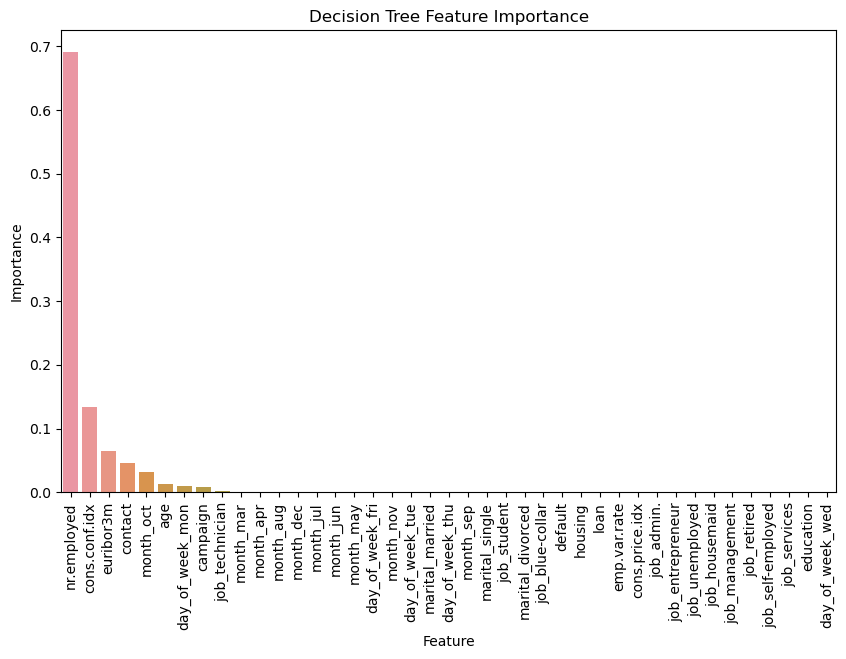

In [73]:
best_dtc = tuned_dtc.best_estimator_
dtc_feat_imp = pd.DataFrame({
    'Feature': X.columns.tolist(), 
    'Importance': best_dtc.feature_importances_}).sort_values(by=['Importance'], ascending=False)

fig = plt.figure(figsize=(10, 6))
plt.title('Decision Tree Feature Importance')
plt.xticks(rotation=90)
sns.barplot(dtc_feat_imp, x='Feature', y='Importance')
plt.show()
fig.tight_layout(rect=(0,.05,1,1)) 
fig.savefig("images/dtc_feat_imp.png", bbox_inches='tight');

In [74]:
max_score = 0
max_threshold = 0
for threshold in [0.5, 0.1, 0.05, 0.04, 0.03, 0.012, 0.01, 0.005]:
    dtc_selector = SelectFromModel(best_dtc, threshold=threshold)
    dtc_selectedFeatures = X_train.columns[dtc_selector.get_support()]
  
    dtc_X_train_selected = dtc_selector.transform(X_train.values) 
    dtc_X_test_selected = dtc_selector.transform(X_test.values)
    
    selected_dtc = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=5, min_samples_leaf=1, min_samples_split=100).fit(dtc_X_train_selected, y_train)
    
    selected_dtc_y_pred = selected_dtc.predict(dtc_X_test_selected)
    selected_dtc_score = round(accuracy_score(y_test, selected_dtc_y_pred), 4)
    if selected_dtc_score > max_score:
        max_score = selected_dtc_score
        max_threshold = threshold
print('Score with all features:', tuned_dtc_test_score)        
print('Best score with selected features:', max_score, ' threshold:', max_threshold)

Score with all features: 0.8696
Best score with selected features: 0.8692  threshold: 0.04


Again, limiting the selected features didn't improve the score.

Although feature selection didn't improve the score, it does show which featres have the most affect on the model.